### Python setup

See `README.md` for python environment setup instructions on OSX using `pyenv` in VSCode.  If you've got another way of getting a modern, viable python environment, feel free to use it.

Here are the versions that I'm using when running this notebook:

In [1]:
%%bash
python -V
pip -V

Python 3.12.2
pip 24.0 from /Users/tednaleid/.pyenv/versions/3.12.2/envs/d2notebooks-3.12.2/lib/python3.12/site-packages/pip (python 3.12)


In [26]:
# install dependencies with `pip` 
! pip install requests pandas matplotlib

### Generate a self-signed cert that we can use for the https redirect during the OAuth login

You'll need to tell your browser to "trust" this cert after the redirect

In [2]:
%%bash
if [[ -f "key.pem" ]]; then
    echo "key.pem already exists, not regenerating it.  Delete if if you'd like to regenerate it."
else
    openssl req -x509 -newkey rsa:4096 -keyout key.pem -out cert.pem -days 365 -nodes -subj "/C=US/ST=California/L=San Francisco/O=My Company/OU=My Division/CN=localhost"
fi

key.pem already exists, not regenerating it.  Delete if if you'd like to regenerate it.


### API Key and Client ID

You'll need an API Key and Client ID to interact with Bungie's API.  You can generate one on Bungie's website: https://www.bungie.net/en/Application

You can generate an application with the "Public" OAuth type with a redirect url of: `https://localhost:7777/oauth-redirect`  - this will be used after the oauth login to get the oauth token that will be used in API requests

The only scope necessary is read access: `Read your Destiny 2 information (Vault, Inventory, and Vendors), as well as Destiny 1 Vault and Inventory data` 

This is what it should look like:

![Image](images/oauth-app-settings.png)


Once you create your application, you should get an `OAuth client_id` and an `API Key`, values for these should be put into `config.json`.  It should look like this:

```
{ "client_id": "your_client_id", "api_key": "your_api_key"}
```

This next cell will read that file in and make the `client_id` and `api_key` values available to the rest of the calls.


In [1]:
from src import config

client_id, api_key = config.load_config()

print(f"client_id length: {len(client_id)}")
print(f"api_key length: {len(api_key)}")

client_id length: 5
api_key length: 32


### Login with OAuth to get a token that'll last for 1 hour

In [2]:
from src.bungie_oauth import BungieAuth
import datetime

# perform oauth login to get the access token used in later requests.  It is good for 1 hour
print("We're using a self-signed certificate to run an HTTPS server on localhost, you'll need to accept the certificate in your browser.")
access_token = BungieAuth(client_id).refresh_oauth_token()

# token is good for 1 hour, print out the time that it expires
expiration_time = datetime.datetime.now() + datetime.timedelta(hours=1)
print(f"Access token successfully acquired at: {datetime.datetime.now().isoformat()} and expires at: {expiration_time.isoformat()}")

We're using a self-signed certificate to run an HTTPS server on localhost, you'll need to accept the certificate in your browser.
Please go to the following URL and authorize the app: https://www.bungie.net/en/oauth/authorize?client_id=22927&response_type=code&state=i15NpR6cgrlFZ016OpEJo0q_FY2BlgI7NfhhX5myN0vIz633H1Qh0qquecwk1zDgdqgSg61ItFAMJ82sQ15DGMxnFWupRvc87wd9gd7UQyM4P2YaaIvajom38YxKPXNz6Tr9i6riY2hMEZMXJZejeca7bElmDuWE3RXrsJ9MAhc=&redirect_uri=https://localhost:7777/
Stopping HTTPS server
Access token successfully acquired at: 2024-05-26T01:34:18.822805 and expires at: 2024-05-26T02:34:18.822659


### Now we're ready to talk to Bungie's API

### Retrieve the membership ID for your user account

Update the `username` field with your bungie username, steam names will have a `#<4 digits>` on the end.  

You will not be able to use my username and have the scripts below work because many of them are getting non-public (but read-only) info about vault equipment.

This same username is used on things like https://dungeon.report to find your user.

In [3]:
username = 'ted#2434'

In [4]:
from src.bungie_api import BungieApi

api = BungieApi(api_key, access_token)

membership_id, profile_type = api.get_primary_membership_id_and_type(username)
print(f"Membership ID: {membership_id}, Profile Type: {profile_type}")

api.get_character_ids_and_classes(membership_id, profile_type)

Checking membership ID 4611686018436088066 with membership type 2
Crosave override found for 4611686018436088066
Membership ID: 4611686018436088066, Profile Type: 2


{'2305843009262789149': 'Titan',
 '2305843009262789151': 'Warlock',
 '2305843009665494246': 'Hunter'}

In [5]:
# retrieve the manifest and item/stat definitions that will be joined with profile data to determine what armor you have in your vault
item_definitions, stat_definitions = api.get_static_definitions()

In [6]:
import json
# access_token, profile_type, and membership_id should be retrieved above 
# using the login_and_get_token and get_primary_membership_id_and_type functions

# https://bungie-net.github.io/multi/schema_Destiny-DestinyComponentType.html#schema_Destiny-DestinyComponentType
# 100 = profile.data.userInfo
# 102 = profileInventory.data.items
# 201 = characterInventories.data[character_id].items
# 205 = characterEquipment.data[character_id].items
# 300 = itemComponents.instances
# 305 = profilePlugSets.data.plugs, characterPlugSets.data[character_id].plugs, itemComponents.sockets

# this gives us all of the information we need for vault armor for this user
profile = api.get_profile(access_token, profile_type, membership_id, [100,102,201,205,300,305,309])

# dump the profile out as json into the data directory
with open('data/profile.json', 'w') as file:
    json.dump(profile, file, indent=4)

print(f"Character profile loaded at:", profile["responseMintedTimestamp"])

Character profile loaded at: 2024-05-26T06:34:33.169Z


In [7]:
# extract all armor pieces out of the profile.  It retrieves from the vault, character inventory, and character equipment
import src.armor as armor
import pandas as pd

profile_armor = armor.ProfileArmor(profile, item_definitions, stat_definitions)

armor_dict = profile_armor.get_armor_dict()

armor_df = pd.DataFrame([{
    **vars(armor), 
    'total_stats': armor.total_stats,
    'is_exotic': armor.is_exotic,
    'class_slot': armor.class_slot
} for armor in armor_dict.values()])

armor_df

,item_name,item_hash,instance_id,rarity,slot,power,mobility,resilience,recovery,discipline,intellect,strength,is_artifice,is_masterworked,d2_class,total_stats,is_exotic,class_slot
0,Tusked Allegiance Helmet,2240729575,6917529815104854677,Legendary,Helmet,1810,2,23,7,21,10,2,False,True,Titan,65,False,Titan Helmet
1,Synthoceps,241462142,6917529871224003792,Exotic,Gauntlets,1810,2,16,13,17,2,10,False,True,Titan,60,True,Titan Gauntlets
2,Warmind's Avatar Chestplate,839296981,6917529857906618905,Legendary,Chest Armor,1810,2,30,2,15,10,6,False,True,Titan,65,False,Titan Chest Armor
3,Ketchkiller's Greaves,1640403802,6917529823402521839,Legendary,Leg Armor,1809,6,22,6,23,8,2,False,True,Titan,67,False,Titan Leg Armor
4,Descending Echo Mark,4050474396,6917529942979833410,Legendary,Class Item,1810,0,0,0,0,0,0,True,True,Titan,0,False,Titan Class Item
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,Techeun's Regalia Grips,164103153,6917529873277044290,Legendary,Gauntlets,1783,18,2,12,14,8,10,False,False,Hunter,64,False,Hunter Gauntlets
268,Vest of Trepidation,2787963735,6917529883192953649,Legendary,Chest Armor,1800,12,8,13,2,21,7,False,False,Hunter,63,False,Hunter Chest Armor
269,Hinterland Vest,2923110818,6917529960103865660,Legendary,Chest Armor,1800,20,12,2,16,2,13,False,False,Hunter,65,False,Hunter Chest Armor
270,Eternal Warrior,2808156426,6917529834873405734,Exotic,Helmet,1600,2,13,17,17,12,2,False,False,Titan,63,True,Titan Helmet


In [8]:
# specific instances of armor in my vault used for spot testing - these will only be in Ted's vault
crown_of_tempests_id=6917529798174050595
corrupting_echo_gloves_id=6917529970716463834
ketchkillers_robes_id=6917529822099480651
deep_explorer_boots_id=6917529796979541985
class_item_id=6917529583788947730
armor_df[armor_df['instance_id'].isin([crown_of_tempests_id, corrupting_echo_gloves_id, ketchkillers_robes_id, deep_explorer_boots_id, class_item_id])]

,item_name,item_hash,instance_id,rarity,slot,power,mobility,resilience,recovery,discipline,intellect,strength,is_artifice,is_masterworked,d2_class,total_stats,is_exotic,class_slot
39,Corrupting Echo Bond,4217390949,6917529583788947730,Legendary,Class Item,1810,0,0,0,0,0,0,True,True,Warlock,0,False,Warlock Class Item
40,Crown of Tempests,3381022969,6917529798174050595,Exotic,Helmet,1810,2,30,2,16,2,16,False,True,Warlock,68,True,Warlock Helmet
50,Corrupting Echo Gloves,2244604734,6917529970716463834,Legendary,Gauntlets,1810,8,9,16,12,2,20,True,True,Warlock,67,False,Warlock Gauntlets
55,Ketchkiller's Robes,3833868247,6917529822099480651,Legendary,Chest Armor,1810,6,22,6,20,12,2,False,True,Warlock,68,False,Warlock Chest Armor
56,Deep Explorer Boots,2819810688,6917529796979541985,Legendary,Leg Armor,1810,2,26,6,22,9,2,True,True,Warlock,67,False,Warlock Leg Armor


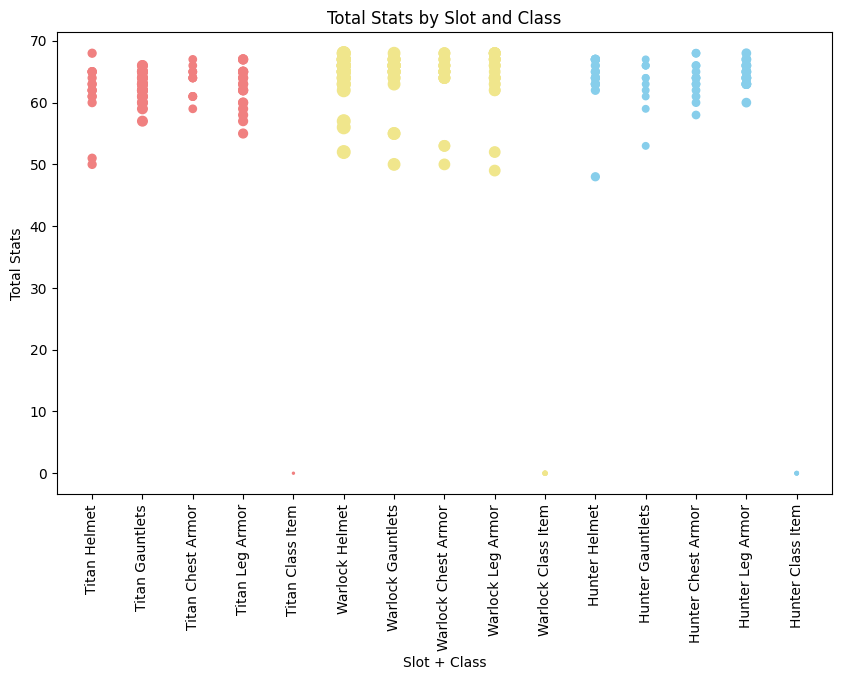

In [9]:
# create a graph that shows total stats by class and slot for all armor in the vault.  The larger the circle, the more we have with that stat total
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a color map for the classes
color_map = {'Hunter': mcolors.CSS4_COLORS['skyblue'], 
             'Titan': mcolors.CSS4_COLORS['lightcoral'], 
             'Warlock': mcolors.CSS4_COLORS['khaki']}
armor_df['color'] = armor_df['d2_class'].map(color_map)

# Calculate the counts for each 'class_slot' value
counts = armor_df['class_slot'].value_counts()

plt.figure(figsize=(10,6))
# Pass the counts as the 's' argument to plt.scatter()
plt.scatter(armor_df['class_slot'], armor_df['total_stats'], s=counts[armor_df['class_slot']] * 2, color=armor_df['color'])
plt.xlabel('Slot + Class')
plt.ylabel('Total Stats')
plt.title('Total Stats by Slot and Class')
plt.xticks(rotation=90)
plt.show()

In [10]:
from itertools import product
from collections import defaultdict
from collections import namedtuple

class ProfileOutfits:

    Outfit = namedtuple('Outfit', ['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength', 'helmet', 'gauntlets', 'chest_armor', 'leg_armor', 'class_item', 'num_artifice'])
    Stats = namedtuple('stats', ['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength'])
    # masterworking helmet, gauntlets, chest armor, leg armor, and class item gives a +10 bonus to each stat in an outfit
    FULL_MASTERWORK_STAT_BONUS = 10

    def __init__(self, armor_dict):
        self.armor_dict = armor_dict
        self.artifice_permutations = {i: self.generate_artifice_permutations(i) for i in range(6)}

    # we want to generate outfits for a given class
    # The high-level algorithm is:

    # 1. filter armor to only include armor for the given class, also filter out class items
    # 2. segregate the armor by whether it is exotic or not
    # 3. group the exotic and non-exotic armor by slot
    def filter_and_group_armor(self, d2_class, slots = ["Helmet", "Gauntlets", "Chest Armor", "Leg Armor", "Class Item"]):
        exotic_armor = defaultdict(list)
        non_exotic_armor = defaultdict(list)
        for armor in self.armor_dict.values():
            if armor.d2_class == d2_class and armor.slot in slots:
                if armor.is_exotic:
                    exotic_armor[armor.slot].append(armor)
                else:
                    non_exotic_armor[armor.slot].append(armor)

        if "Class Item" in non_exotic_armor:
            # class items all have the same stats, the only option is if one is artifice.  Pick one and remove the rest
            for armor in non_exotic_armor["Class Item"]:
                if armor.is_artifice:
                    non_exotic_armor["Class Item"] = [armor]
                    break

            if len(non_exotic_armor["Class Item"]) > 1:
                non_exotic_armor["Class Item"] = [non_exotic_armor["Class Item"][0]]

        return exotic_armor, non_exotic_armor

    # 4. generate all possible outfits using non-exotic armor
    # 5. add in all possible outfits using a single piece of exotic armor
    def generate_class_outfits(self, d2_class):
        outfits = []

        # filter armor to only include armor for the given class and slots
        exotic_armor, non_exotic_armor = self.filter_and_group_armor(d2_class, ["Helmet", "Gauntlets", "Chest Armor", "Leg Armor", "Class Item"])

        # append all possible non-exotic armor combinations

        # do we care about non-exotic armor?
        # self.append_outfit_permutations(outfits, non_exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])

        # we can only have exotic armor in a single slot, add all outfits with a single slot of exotic armor
        self.append_outfit_permutations(outfits, exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])
        self.append_outfit_permutations(outfits, non_exotic_armor["Helmet"], exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])
        self.append_outfit_permutations(outfits, non_exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])
        self.append_outfit_permutations(outfits, non_exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], exotic_armor["Leg Armor"], non_exotic_armor["Class Item"])

        # as of right now, there is no exotic class item.  there will be in TFS, but unless it has stats better than a legendary class item, we don't care
        # append_outfit_permutations(outfits, non_exotic_armor["Helmet"], non_exotic_armor["Gauntlets"], non_exotic_armor["Chest Armor"], non_exotic_armor["Leg Armor"], exotic_armor["Class Item"])

        return outfits

    def generate_artifice_permutations(self, num_artifice):
        # Generate all permutations artifice mods that could be assigned to each stat
        all_permutations = product(range(0, num_artifice + 1), repeat=6)

        # Filter the permutations to only include ones with that have the right number of artifice applied
        valid_permutations = [perm for perm in all_permutations if sum(perm) == num_artifice]

        # for each artifice in a slot, it applies a +3 bonus to that stat
        return [self.Stats(*(i*3 for i in perm)) for perm in valid_permutations]



    def round_to_useful_tier(self, stat):
        # stats above 100 aren't useful.  T10 is the highest tier
        if stat > 100:
            return 100

        # half tiers can be useful as there are 5 point mods, so we want to round down to the nearest 5
        return stat - (stat % 5)

    def append_outfit_permutations(self, outfits, helmets, gauntlets, chest_armors, leg_armors, class_items):
        for helmet, gauntlet, chest_armor, leg_armor, class_item in product(helmets, gauntlets, chest_armors, leg_armors, class_items):
            # we want to add the masterwork stat bonus
            # armor pieces have base stats, without any mods or masterworking
            base_mobility = self.FULL_MASTERWORK_STAT_BONUS + helmet.mobility + gauntlet.mobility + chest_armor.mobility + leg_armor.mobility + class_item.mobility
            base_resilience = self.FULL_MASTERWORK_STAT_BONUS + helmet.resilience + gauntlet.resilience + chest_armor.resilience + leg_armor.resilience + class_item.resilience
            base_recovery = self.FULL_MASTERWORK_STAT_BONUS + helmet.recovery + gauntlet.recovery + chest_armor.recovery + leg_armor.recovery + class_item.recovery
            base_discipline = self.FULL_MASTERWORK_STAT_BONUS + helmet.discipline + gauntlet.discipline + chest_armor.discipline + leg_armor.discipline + class_item.discipline
            base_intellect = self.FULL_MASTERWORK_STAT_BONUS + helmet.intellect + gauntlet.intellect + chest_armor.intellect + leg_armor.intellect + class_item.intellect
            base_strength = self.FULL_MASTERWORK_STAT_BONUS + helmet.strength + gauntlet.strength + chest_armor.strength + leg_armor.strength + class_item.strength

            num_artifice = helmet.is_artifice + gauntlet.is_artifice + chest_armor.is_artifice + leg_armor.is_artifice + class_item.is_artifice

            self.append_outfit_permutation(outfits, base_mobility, base_resilience, base_recovery, base_discipline, base_intellect, base_strength, helmet.instance_id, gauntlet.instance_id, chest_armor.instance_id, leg_armor.instance_id, class_item.instance_id, num_artifice)

    # recursively apply any artifice to the outfit
    def append_outfit_permutation(self, outfits, mobility, resilience, recovery, discipline, intellect, strength, helmet, gauntlets, chest_armor, leg_armor, class_item, num_artifice):
        if num_artifice == 0:
            outfits.append(self.Outfit(
                mobility=self.round_to_useful_tier(mobility),
                resilience=self.round_to_useful_tier(resilience),
                recovery=self.round_to_useful_tier(recovery),
                discipline=self.round_to_useful_tier(discipline),
                intellect=self.round_to_useful_tier(intellect),
                strength=self.round_to_useful_tier(strength),
                helmet=helmet,
                gauntlets=gauntlets,
                chest_armor=chest_armor,
                leg_armor=leg_armor,
                class_item=class_item,
                num_artifice=num_artifice
            ))
        else:

            # todo: start here - we need to come up with some algorithm for deleting outfits that are dominated by other outfits
            # we could use stat priority like DIM does to try to turn it into a tree
            # but I don't think we want that for our full set of permutations

            # right now we're adding stuff like this which has double the stats that we really can use:
            # (10,10,10,10,10,25)
            # (10,10,10,10,15,25)
            # (10,10,10,10,20,20)
            # (10,10,10,10,25,10)

            # maybe find peak outfits?

            # create a set of stats that we can use to only build outfits with a unique set of stats, some combinations don't create unique useful tiers
            # ex: if mobility is 27 adding +3 is the same as adding +6, they both round to 30
            useful_stats_permutations = set()

            for artifice_bonus in self.artifice_permutations[num_artifice]:
                useful_stats_permutations.add(self.Stats(
                    mobility=self.round_to_useful_tier(mobility + artifice_bonus.mobility),
                    resilience=self.round_to_useful_tier(resilience + artifice_bonus.resilience),
                    recovery=self.round_to_useful_tier(recovery + artifice_bonus.recovery),
                    discipline=self.round_to_useful_tier(discipline + artifice_bonus.discipline),
                    intellect=self.round_to_useful_tier(intellect + artifice_bonus.intellect),
                    strength=self.round_to_useful_tier(strength + artifice_bonus.strength)
                ))
            
            for useful_stats in useful_stats_permutations:
                outfits.append(self.Outfit(
                    mobility=useful_stats.mobility,
                    resilience=useful_stats.resilience,
                    recovery=useful_stats.recovery,
                    discipline=useful_stats.discipline,
                    intellect=useful_stats.intellect,
                    strength=useful_stats.strength,
                    helmet=helmet,
                    gauntlets=gauntlets,
                    chest_armor=chest_armor,
                    leg_armor=leg_armor,
                    class_item=class_item,
                    num_artifice=num_artifice
                ))

    # identify all non-class item armor that has the same or worse stats than another piece of armor of the same rarity and type
    def find_eclipsed_armor(self):
        eclipsed_armor = []
        armor_list = list(self.armor_dict.values())

        # sort by power level, low to high
        armor_list.sort(key=lambda x: x.power)

        for i, armor in enumerate(armor_list):
            if armor.slot == "Class Item":
                continue
            for other_armor in armor_list[i+1:]:
                if armor.rarity != other_armor.rarity:
                    continue
                # only compare exotic armor pieces that are the same item
                if armor.rarity == "Exotic" and armor.item_hash != other_armor.item_hash:
                    continue
                if armor.class_slot == other_armor.class_slot and armor.instance_id != other_armor.instance_id:
                    if armor.mobility <= other_armor.mobility and armor.resilience <= other_armor.resilience and armor.recovery <= other_armor.recovery and armor.discipline <= other_armor.discipline and armor.intellect <= other_armor.intellect and armor.strength <= other_armor.strength:
                        eclipsed_armor.append((armor, other_armor))
                    elif other_armor.mobility <= armor.mobility and other_armor.resilience <= armor.resilience and other_armor.recovery <= armor.recovery and other_armor.discipline <= armor.discipline and other_armor.intellect <= armor.intellect and other_armor.strength <= armor.strength:
                        eclipsed_armor.append((other_armor, armor))
        return eclipsed_armor


### Identify all armor that is eclipsed by another piece of armor and can be safely deleted

In [11]:
profile_outfits = ProfileOutfits(armor_dict)

# print out all armor that has the same or worse stats than another piece of armor of the same rarity and type
for lesser_armor, greater_armor in profile_outfits.find_eclipsed_armor():
    print(f"id:{lesser_armor.instance_id} id:{greater_armor.instance_id}")
    print(f"mob {lesser_armor.mobility}\tres {lesser_armor.resilience}\trec {lesser_armor.recovery}\tdis {lesser_armor.discipline}\tint {lesser_armor.intellect}\tstr {lesser_armor.strength}\t name {lesser_armor.item_name}")
    print(f"mob {greater_armor.mobility}\tres {greater_armor.resilience}\trec {greater_armor.recovery}\tdis {greater_armor.discipline}\tint {greater_armor.intellect}\tstr {greater_armor.strength}\t name {greater_armor.item_name}")
    

id:6917529664322015082 id:6917529882311993983
mob 20	res 2	rec 10	dis 15	int 15	str 2	 name Tusked Allegiance Mask
mob 20	res 2	rec 10	dis 15	int 15	str 2	 name Techeun's Regalia Mask
id:6917530001406404775 id:6917529837738329352
mob 2	res 20	rec 7	dis 18	int 2	str 8	 name Ego Talon IV
mob 2	res 21	rec 10	dis 20	int 2	str 10	 name Tusked Allegiance Hood
id:6917529967583481167 id:6917529857906618905
mob 2	res 30	rec 2	dis 15	int 10	str 6	 name Wyrmguard Chestplate
mob 2	res 30	rec 2	dis 15	int 10	str 6	 name Warmind's Avatar Chestplate
id:6917530000351948132 id:6917529796979541985
mob 2	res 16	rec 6	dis 17	int 6	str 2	 name Prodigal Steps
mob 2	res 26	rec 6	dis 22	int 9	str 2	 name Deep Explorer Boots
id:6917529858495446275 id:6917529973673406209
mob 2	res 30	rec 2	dis 22	int 6	str 6	 name Warmind's Avatar Vest
mob 2	res 30	rec 2	dis 22	int 6	str 6	 name Wyrmguard Tunic
id:6917530001406404775 id:6917529855693975489
mob 2	res 20	rec 7	dis 18	int 2	str 8	 name Ego Talon IV
mob 2	res 20	re

### Generate all possible outfits for each class type

In [12]:
profile_outfits = ProfileOutfits(armor_dict)

# generate outfit permutations for each class
d2_class = "Hunter"
hunter_outfits = profile_outfits.generate_class_outfits(d2_class)
print(f"Generated {len(hunter_outfits)} outfit permutations for {d2_class}")

d2_class = "Titan"
titan_outfits = profile_outfits.generate_class_outfits(d2_class)
print(f"Generated {len(titan_outfits)} outfit permutations for {d2_class}")

d2_class = "Warlock"
warlock_outfits = profile_outfits.generate_class_outfits(d2_class)
print(f"Generated {len(warlock_outfits)} outfit permutations for {d2_class}")

Generated 51144 outfit permutations for Hunter
Generated 80843 outfit permutations for Titan
Generated 6445426 outfit permutations for Warlock


In [13]:
# modify to the class you want to work with below
# outfits = hunter_outfits
# outfits = titan_outfits
outfits = warlock_outfits

In [17]:
import polars as pl
from polars import col

ploutfits_df = pl.DataFrame(outfits)
ploutfits_df = ploutfits_df.with_columns(
    (col('mobility') + col('resilience') + col('recovery') + col('discipline') + col('intellect') + col('strength')).alias('total_points')
)

# sort by total_points
ploutfits_df = ploutfits_df.sort('total_points', 'resilience')
ploutfits_df

mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,total_points
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
40,45,40,55,40,35,6917529673019349339,6917530000351944322,6917530009187077342,6917530000351948132,6917529583788947730,1,255
40,55,30,45,45,40,6917529944591452960,6917530000351944322,6917529999962957167,6917530000351948132,6917529583788947730,1,255
30,60,40,55,35,35,6917529673019349339,6917530000351944322,6917529999962957167,6917530000351948132,6917529583788947730,1,255
50,35,50,30,45,50,6917530000351944949,6917530000351944322,6917529999962957167,6917529998335931319,6917529583788947730,1,260
45,40,45,50,45,35,6917529673019349339,6917530000351944322,6917530009187077342,6917530005255852048,6917529583788947730,1,260
…,…,…,…,…,…,…,…,…,…,…,…,…
25,100,40,85,35,50,6917529998009338447,6917529784505163382,6917529784431753951,6917529796979541985,6917529583788947730,4,335
35,100,30,100,40,30,6917529798174050595,6917529784505163382,6917529861511568747,6917529796979541985,6917529583788947730,4,335
25,100,40,75,35,60,6917529998009338447,6917529784505163382,6917529796975066049,6917529796979541985,6917529583788947730,4,335


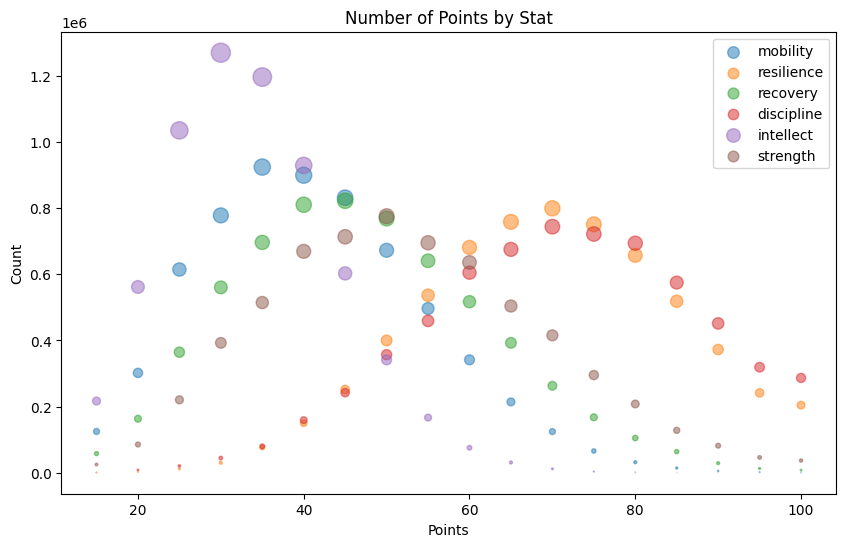

In [41]:
import polars as pl
import matplotlib.pyplot as plt

# Reshape the DataFrame to long format
long_df = ploutfits_df.melt(
    value_vars=["mobility", "resilience", "recovery", "discipline", "intellect", "strength"],
)

# Rename the columns to 'stat' and 'points'
long_df = long_df.with_columns(
    long_df["variable"].alias("stat"),
    long_df["value"].alias("points"),
)

# Count the number of outfits for each point total for each stat
counts_df = long_df.group_by(["stat", "points"]).agg(pl.count("stat").alias("count"))

# Convert to pandas for easier plotting
counts_df = counts_df.to_pandas()

# Create a scatter plot
plt.figure(figsize=(10, 6))
for stat in ["mobility", "resilience", "recovery", "discipline", "intellect", "strength"]:
    stat_df = counts_df[counts_df["stat"] == stat]
    plt.scatter(
        stat_df["points"],
        stat_df["count"],  # Y-axis
        s=stat_df["count"] * 0.00015,  # Scale the count values for dot size
        alpha=0.5,
        label=stat,
    )
plt.xlabel("Points")
plt.ylabel("Count")
plt.title("Number of Points by Stat")
plt.legend()
plt.show()

In [28]:
print(ploutfits_df.dtypes)
print(ploutfits_df.shape)
print(ploutfits_df.describe()) 

[Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64]
(9088688, 13)
shape: (9, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ mobility  ┆ resilienc ┆ recovery  ┆ … ┆ leg_armor ┆ class_ite ┆ num_artif ┆ total_po │
│ ---       ┆ ---       ┆ e         ┆ ---       ┆   ┆ ---       ┆ m         ┆ ice       ┆ ints     │
│ str       ┆ f64       ┆ ---       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆           ┆   ┆           ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 9.088688e ┆ 9.088688e ┆ 9.088688e ┆ … ┆ 9.088688e ┆ 9.088688e ┆ 9.088688e ┆ 9.088688 │
│           ┆ 6         ┆ 6         ┆ 6         ┆   ┆ 6         ┆ 6         ┆ 6         ┆ e6       │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0  

In [17]:
# find rows in ploutfits_df that are duplicate rows for all fields - should not happen
ploutfits_df.filter(ploutfits_df.is_duplicated())


mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,total_points
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64


In [29]:
# find rows where the mobility, resilience, recovery, discipline, intellect, and strength are all equal to or lower than another row
# this is a way to identify outfits that are eclipsed by another outfit

# Define the columns of interest
columns_of_interest = ["mobility", "resilience", "recovery", "discipline", "intellect", "strength"]

# Create a subset DataFrame
subset_df = ploutfits_df.select(columns_of_interest)

# Initialize an empty list to collect indices
result_indices = []

# Iterate through each row and compare it with every other row
for i in range(subset_df.shape[0]):
    row_i = subset_df.row(i)
    for j in range(subset_df.shape[0]):
        if i != j:
            row_j = subset_df.row(j)
            if all(ri <= rj for ri, rj in zip(row_i, row_j)):
                result_indices.append(i)
                break

# Filter the original DataFrame using the collected indices
result_df = ploutfits_df.filter(pl.col("index").is_in(result_indices))

# Display the result
result_df



KeyboardInterrupt: 

TODO start here: maybe the tree way of dealing with things is the right way to find peak outfits? 

Could turn it into sort of a trie where we insert outfits based on stats in order.   

In [19]:
import pandas as pd

# convert outfits to a dataframe
outfits_df = pd.DataFrame(outfits)
outfits_df['total_points'] = outfits_df[['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength']].sum(axis=1)
outfits_df

,mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,total_points
0,25,100,30,85,30,45,6917529556443339535,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,3,315
1,25,100,25,90,30,45,6917529556443339535,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,3,315
2,25,100,25,80,30,50,6917529556443339535,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,3,310
3,30,100,25,80,30,45,6917529556443339535,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,3,310
4,25,100,25,85,35,45,6917529556443339535,6917529838031225999,6917529850937976682,6917529906176854077,6917529583788947730,3,315
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9088683,55,50,50,70,35,55,6917529863334560802,6917529954114346693,6917529862445297720,6917529965587176122,6917529583788947730,2,315
9088684,55,50,50,70,30,55,6917529863334560802,6917529954114346693,6917529862445297720,6917529965587176122,6917529583788947730,2,310
9088685,60,50,50,70,30,55,6917529863334560802,6917529954114346693,6917529862445297720,6917529965587176122,6917529583788947730,2,315
9088686,55,50,55,75,30,55,6917529863334560802,6917529954114346693,6917529862445297720,6917529965587176122,6917529583788947730,2,320


In [21]:
# one of my specific outfits I can see in DIM - shows all permutations of this outfit that have unique stat totals
crown_of_tempests_id=6917529798174050595
corrupting_echo_gloves_id=6917529970716463834
ketchkillers_robes_id=6917529822099480651
deep_explorer_boots_id=6917529796979541985
class_item_id=6917529583788947730
outfit = outfits_df.loc[
    (outfits_df['helmet'] == crown_of_tempests_id) & 
    (outfits_df['gauntlets'] == corrupting_echo_gloves_id) & 
    (outfits_df['chest_armor'] == ketchkillers_robes_id) &
    (outfits_df['leg_armor'] == deep_explorer_boots_id) &
    (outfits_df['class_item'] == class_item_id)]

outfit

,mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,total_points
2753506,25,95,40,80,35,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3,325
2753507,30,95,40,85,35,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3,335
2753508,35,95,40,80,35,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3,335
2753509,25,100,45,80,35,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3,335
2753510,30,95,40,80,35,55,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3,335
2753511,25,100,40,80,35,55,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3,335
2753512,30,95,40,80,35,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3,330
2753513,25,95,40,80,40,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3,330
2753514,25,100,40,85,35,50,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3,335
2753515,25,95,40,80,35,55,6917529798174050595,6917529970716463834,6917529822099480651,6917529796979541985,6917529583788947730,3,330


In [22]:
# Sort by total_points
sorted_df = outfits_df.sort_values('total_points', ascending=False)

# Drop duplicate rows based on the stat columns
unique_df = sorted_df.drop_duplicates(subset=['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength'])

unique_df

,mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,total_points
49103,45,90,40,85,30,50,6917529556443339535,6917529970716463834,6917529861511568747,6917529796979541985,6917529583788947730,5,340
1733356,40,70,55,95,35,45,6917529861485659605,6917529970716463834,6917529861511568747,6917529796979541985,6917529583788947730,5,340
2754655,35,80,55,70,25,75,6917529798174050595,6917529970716463834,6917529970723712268,6917529796979541985,6917529583788947730,4,340
1734506,45,60,65,85,25,60,6917529861485659605,6917529970716463834,6917529861511568747,6917529954558131477,6917529583788947730,4,340
134134,30,95,40,75,40,60,6917529556443339535,6917529557407159661,6917529784431753951,6917529796979541985,6917529583788947730,5,340
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101481,40,45,40,45,45,35,6917530000351944949,6917530000351944322,6917529999962957167,6917530000351948132,6917529583788947730,1,250
2101480,40,45,45,45,40,35,6917530000351944949,6917530000351944322,6917529999962957167,6917530000351948132,6917529583788947730,1,250
614784,30,55,40,60,30,35,6917529999962955646,6917530005622390869,6917529999962957167,6917530000351948132,6917529583788947730,1,250
2101479,40,45,40,45,40,40,6917530000351944949,6917530000351944322,6917529999962957167,6917530000351948132,6917529583788947730,1,250


In [23]:
from itertools import combinations

# Define a function that checks if any combination of 3 stats totals up to 250, which would allow a triple 100 build with five 10-point mods
def has_three_stats_totaling_250(row):
    stats = ['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength']
    return any(sum(row[stat] for stat in combination) == 250 for combination in combinations(stats, 3))

mask = unique_df.apply(has_three_stats_totaling_250, axis=1)

filtered_df = unique_df[mask]

filtered_df

,mobility,resilience,recovery,discipline,intellect,strength,helmet,gauntlets,chest_armor,leg_armor,class_item,num_artifice,total_points
6084931,20,80,70,100,25,40,6917529861485659605,6917529936709740897,6917529784431753951,6917529862711137071,6917529583788947730,4,335
1725630,20,80,70,100,40,25,6917529861485659605,6917529784505163382,6917529862700452273,6917529861820030545,6917529583788947730,5,335
684418,80,70,25,100,35,25,6917529862717277414,6917529860806551003,6917529861511568747,6917529796979541985,6917529583788947730,5,335
684427,75,75,25,100,35,25,6917529862717277414,6917529860806551003,6917529861511568747,6917529796979541985,6917529583788947730,5,335
1701414,25,85,65,100,35,25,6917529861485659605,6917529838031225999,6917529861527043051,6917529796979541985,6917529583788947730,5,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5250928,80,70,15,100,15,15,6917529862437575151,6917529936709740897,6917529861511568747,6917529862122801761,6917529583788947730,3,295
5250933,75,75,15,100,15,15,6917529862437575151,6917529936709740897,6917529861511568747,6917529862122801761,6917529583788947730,3,295
5590646,70,80,15,100,15,15,6917529862412909583,6917529936709740897,6917529861511568747,6917529862122801761,6917529583788947730,3,295
5590665,60,90,15,100,15,15,6917529862412909583,6917529936709740897,6917529861511568747,6917529862122801761,6917529583788947730,3,295


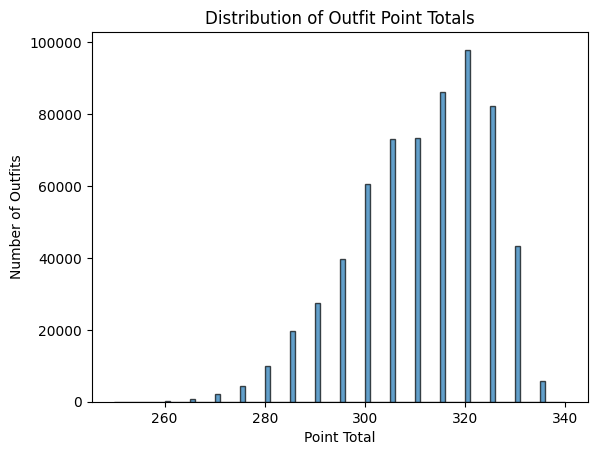

In [25]:
import matplotlib.pyplot as plt

# Calculate the point totals
point_totals = unique_df['total_points']

# Create a histogram of the point totals
plt.hist(point_totals, bins=range(min(point_totals), max(point_totals) + 1), alpha=0.7, edgecolor='black')

# Set the title and labels
plt.title('Distribution of Outfit Point Totals')
plt.xlabel('Point Total')
plt.ylabel('Number of Outfits')

# Show the plot
plt.show()

In [26]:
# Create a dictionary to store the best outfit for each stat
best_outfits = {}

# Find the best outfit for each stat
for stat in ['mobility', 'resilience', 'recovery', 'discipline', 'intellect', 'strength']:
    # Sort by the stat, then the total_points
    best_outfit = outfits_df.sort_values([stat, 'total_points']).iloc[-1]
    best_outfits[stat] = best_outfit

best_outfits


{'mobility': mobility                        100
 resilience                       45
 recovery                         20
 discipline                       90
 intellect                        25
 strength                         50
 helmet          6917529966660829977
 gauntlets       6917529950606308371
 chest_armor     6917529861511568747
 leg_armor       6917529862122801761
 class_item      6917529583788947730
 num_artifice                      2
 total_points                    330
 Name: 5708749, dtype: int64,
 'resilience': mobility                         40
 resilience                      100
 recovery                         25
 discipline                       85
 intellect                        35
 strength                         50
 helmet          6917529862412909583
 gauntlets       6917529838031225999
 chest_armor     6917529784431753951
 leg_armor       6917529953239392961
 class_item      6917529583788947730
 num_artifice                      4
 total_points      

# Tests

In [3]:
import unittest
import random
from src.armor import Armor, ProfileArmor, random_64_int
import json

random.seed(42)

class TestOutfits(unittest.TestCase):
    def armor_list_to_dict(self, armor_list):
        return {armor.instance_id: armor for armor in armor_list}

    def random_stat(self):
        return random.randint(1,42)
    
    def random_armor(self, slot, rarity="Legendary", item_hash=None):
        if item_hash is None:
            item_hash = random_64_int()
        return Armor(slot=slot, rarity=rarity, item_hash=item_hash, mobility=self.random_stat(), resilience=self.random_stat(), recovery=self.random_stat(), discipline=self.random_stat(), intellect=self.random_stat(), strength=self.random_stat())
    
    def setUp(self):
        self.titan_helmet = Armor(slot="Helmet", mobility=6, resilience=6, recovery=6, discipline=6, intellect=6, strength=6, d2_class="Titan")
        self.helmet = Armor(slot="Helmet", mobility=6, resilience=6, recovery=6, discipline=6, intellect=6, strength=6)
        self.artifice_helmet = Armor(slot="Helmet", mobility=6, resilience=6, recovery=6, discipline=6, intellect=6, strength=6, is_artifice=True)
        self.gauntlets = Armor(slot="Gauntlets", mobility=7, resilience=7, recovery=7, discipline=7, intellect=7, strength=7)
        self.chest_armor = Armor(slot="Chest Armor", mobility=8, resilience=8, recovery=8, discipline=8, intellect=8, strength=8)
        self.leg_armor = Armor(slot="Leg Armor", mobility=9, resilience=9, recovery=9, discipline=9, intellect=9, strength=9)
        self.artifice_leg_armor = Armor(slot="Leg Armor", mobility=11, resilience=11, recovery=11, discipline=5, intellect=5, strength=20, is_artifice=True)
        self.class_item = Armor(slot="Class Item", mobility=0, resilience=0, recovery=0, discipline=0, intellect=0, strength=0)
        self.exotic_helmet = Armor(slot="Helmet", item_hash="veritys_brow", rarity="Exotic", mobility=2, resilience=20, recovery=10, discipline=30, intellect=2, strength=2)
        self.exotic_helmet2 = Armor(slot="Helmet", item_hash="veritys_brow", rarity="Exotic", mobility=11, resilience=11, recovery=11, discipline=11, intellect=11, strength=11)
        self.exotic_gauntlets = Armor(slot="Gauntlets", item_hash="necrotic_grips", rarity="Exotic", mobility=10, resilience=10, recovery=10, discipline=10, intellect=10, strength=10)

        # all armor pieces in a dictionary keyed by instance_id
        self.armor_dict = self.armor_list_to_dict([
            self.titan_helmet,
            self.helmet,
            self.artifice_helmet,
            self.gauntlets,
            self.chest_armor,
            self.leg_armor,
            self.artifice_leg_armor,
            self.class_item,
            self.exotic_helmet,
            self.exotic_helmet2,
            self.exotic_gauntlets
        ])

        # all unspecified stats are zero
        self.helmet_0 = Armor(slot="Helmet")
        self.gauntlets_0 = Armor(slot="Gauntlets")
        self.chest_armor_0 = Armor(slot="Chest Armor")
        self.leg_armor_0 = Armor(slot="Leg Armor")
        self.class_item_0 = Armor(slot="Class Item")

    def test_armor(self):
        armor = self.helmet
        self.assertEqual(armor.total_stats, 36)
        self.assertEqual(armor.class_slot, "Warlock Helmet")
        self.assertFalse(armor.is_exotic)

        exotic_armor = self.exotic_helmet
        self.assertTrue(exotic_armor.is_exotic)

    def test_filter_and_group_armor(self):
        profile_outfits = ProfileOutfits(self.armor_dict)
        exotic_armor, non_exotic_armor = profile_outfits.filter_and_group_armor("Warlock")

        self.assertIsNotNone(exotic_armor)
        self.assertEqual(len(exotic_armor), 2)
        self.assertEqual(exotic_armor["Helmet"], [self.exotic_helmet, self.exotic_helmet2])
        self.assertEqual(exotic_armor["Gauntlets"], [self.exotic_gauntlets])
        self.assertIsNotNone(non_exotic_armor)
        self.assertEqual(len(non_exotic_armor), 5)
        self.assertEqual(non_exotic_armor["Helmet"], [self.helmet, self.artifice_helmet])
        self.assertEqual(non_exotic_armor["Gauntlets"], [self.gauntlets])
        self.assertEqual(non_exotic_armor["Chest Armor"], [self.chest_armor])
        self.assertEqual(non_exotic_armor["Leg Armor"], [self.leg_armor, self.artifice_leg_armor])
        self.assertEqual(non_exotic_armor["Class Item"], [self.class_item])

        exotic_armor, non_exotic_armor = profile_outfits.filter_and_group_armor("Titan")
        self.assertEqual(len(exotic_armor), 0)
        self.assertEqual(len(non_exotic_armor), 1)
        self.assertEqual(non_exotic_armor["Helmet"], [self.titan_helmet])

    def test_generate_class_outfits(self):
        armor_dict = self.armor_list_to_dict([
            self.helmet,
            self.gauntlets,
            self.chest_armor,
            self.leg_armor,
            self.class_item,
            self.exotic_helmet,
            self.exotic_helmet2,
            self.exotic_gauntlets
        ])
        profile_outfits = ProfileOutfits(armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 4)

        # point totals would be 44 for each stat, but we round down to the nearest 5 for the tier
        self.assertEqual(outfits[0], ProfileOutfits.Outfit(mobility=40, resilience=40, recovery=40, discipline=40, intellect=40, strength=40, helmet=self.helmet.instance_id, gauntlets=self.gauntlets.instance_id, chest_armor=self.chest_armor.instance_id, leg_armor=self.leg_armor.instance_id, class_item=self.class_item.instance_id, num_artifice=0))
        self.assertEqual(outfits[1], ProfileOutfits.Outfit(mobility=35, resilience=50, recovery=40, discipline=60, intellect=35, strength=35, helmet=self.exotic_helmet.instance_id, gauntlets=self.gauntlets.instance_id, chest_armor=self.chest_armor.instance_id, leg_armor=self.leg_armor.instance_id, class_item=self.class_item.instance_id, num_artifice=0))
        self.assertEqual(outfits[2], ProfileOutfits.Outfit(mobility=45, resilience=45, recovery=45, discipline=45, intellect=45, strength=45, helmet=self.exotic_helmet2.instance_id, gauntlets=self.gauntlets.instance_id, chest_armor=self.chest_armor.instance_id, leg_armor=self.leg_armor.instance_id, class_item=self.class_item.instance_id, num_artifice=0))
        self.assertEqual(outfits[3], ProfileOutfits.Outfit(mobility=40, resilience=40, recovery=40, discipline=40, intellect=40, strength=40, helmet=self.helmet.instance_id, gauntlets=self.exotic_gauntlets.instance_id, chest_armor=self.chest_armor.instance_id, leg_armor=self.leg_armor.instance_id, class_item=self.class_item.instance_id, num_artifice=0))

    def test_generate_many_class_outfits(self):
        armor_list=[]
        for i in range(10):
            armor_list.append(self.random_armor("Helmet"))
            armor_list.append(self.random_armor("Gauntlets"))
            armor_list.append(self.random_armor("Chest Armor"))
            armor_list.append(self.random_armor("Leg Armor"))
            armor_list.append(self.random_armor("Class Item"))

        armor_dict = self.armor_list_to_dict(armor_list)
        profile_outfits = ProfileOutfits(armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        # 4 slots with 20 pieces per slot, 10^4 = 10,000
        self.assertEqual(len(outfits), 10**4)

        for i in range(2):
            armor_list.append(self.random_armor("Helmet", "Exotic"))
            armor_list.append(self.random_armor("Gauntlets", "Exotic"))
            armor_list.append(self.random_armor("Leg Armor", "Exotic"))
            armor_list.append(self.random_armor("Chest Armor", "Exotic"))

        armor_dict = self.armor_list_to_dict(armor_list)
        profile_outfits = ProfileOutfits(armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        # same 4 slots with 10 legendary pieces per slot, but now 2 exotic pieces per slot that each need to be combined with 3 slots of 10 legendary pieces 
        self.assertEqual(len(outfits), 10**4 + 8 * 10**3)

    def test_outfit_permutations_zero_artifice(self):
        no_artifice_armor_dict = self.armor_list_to_dict([self.helmet_0, self.gauntlets_0, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(no_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 1)
        # stats in outfit are 10 as we're assuming all armor pieces are masterworked, even though they have all stats at zero
        self.assertEqual(outfits[0], ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=10, intellect=10, strength=10, helmet=self.helmet_0.instance_id, gauntlets=self.gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=0))

    def test_outfit_permutations_one_artifice_stats_zero(self):
        # if we have one piece of artifice armor, but the 3 points it gives doesn't increase a tier, we'll still only have 1 outfit
        artifice_helmet_0 = Armor(slot="Helmet", is_artifice=True) # all stats still at zero
        one_artifice_armor_dict = self.armor_list_to_dict([artifice_helmet_0, self.gauntlets_0, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(one_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 1)
        self.assertEqual(outfits[0], ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_0.instance_id, gauntlets=self.gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=1))

    def test_outfit_permutations_one_artifice_stats_two(self):
        # if we have one piece of artifice armor, but the 2 base points it has are enough to get it close enough to the next tier, we'll have 6 outfits, one for each stat bumped up
        artifice_helmet_2 = Armor(slot="Helmet", mobility=2, resilience=2, recovery=2, discipline=2, intellect=2, strength=2, is_artifice=True)
        one_artifice_armor_dict = self.armor_list_to_dict([artifice_helmet_2, self.gauntlets_0, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(one_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 6)
        self.assertIn(ProfileOutfits.Outfit(mobility=15, resilience=10, recovery=10, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=self.gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=1), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=15, recovery=10, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=self.gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=1), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=15, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=self.gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=1), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=15, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=self.gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=1), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=10, intellect=15, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=self.gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=1), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=10, intellect=10, strength=15, helmet=artifice_helmet_2.instance_id, gauntlets=self.gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=1), outfits)

    def test_outfit_permutations_two_artifice_stats_zero(self):
        # if we have two pieces of artifice armor, but we're starting with all stats ending in 0, we'll get 6 outfits as we can add 6 to each stat
        artifice_helmet_0 = Armor(slot="Helmet", is_artifice=True) # all stats still at zero
        artifice_gauntlets_0 = Armor(slot="Gauntlets", mobility=0, resilience=0, recovery=0, discipline=0, intellect=0, strength=0, is_artifice=True)

        two_artifice_armor_dict = self.armor_list_to_dict([artifice_helmet_0, artifice_gauntlets_0, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(two_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 7)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_0.instance_id, gauntlets=artifice_gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=15, resilience=10, recovery=10, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_0.instance_id, gauntlets=artifice_gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=15, recovery=10, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_0.instance_id, gauntlets=artifice_gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=15, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_0.instance_id, gauntlets=artifice_gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=15, intellect=10, strength=10, helmet=artifice_helmet_0.instance_id, gauntlets=artifice_gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=10, intellect=15, strength=10, helmet=artifice_helmet_0.instance_id, gauntlets=artifice_gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=10, intellect=10, strength=15, helmet=artifice_helmet_0.instance_id, gauntlets=artifice_gauntlets_0.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)

    def test_outfit_permutations_two_artifice_stats_two(self):
        # # if we have two pieces of artifice armor, and we start with base stats of 4 in each stat, we'll get permutations we can add either 6 to every stat or 3 to 2 stats
        artifice_helmet_2 = Armor(slot="Helmet", mobility=2, resilience=2, recovery=2, discipline=2, intellect=2, strength=2, is_artifice=True)
        artifice_gauntlets_2 = Armor(slot="Gauntlets", mobility=2, resilience=2, recovery=2, discipline=2, intellect=2, strength=2, is_artifice=True)

        two_artifice_armor_dict = self.armor_list_to_dict([artifice_helmet_2, artifice_gauntlets_2, self.chest_armor_0, self.leg_armor_0, self.class_item_0])

        profile_outfits = ProfileOutfits(two_artifice_armor_dict)
        outfits = profile_outfits.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits), 21)

        self.assertIn(ProfileOutfits.Outfit(mobility=20, resilience=10, recovery=10, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=20, recovery=10, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=20, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=20, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=10, intellect=20, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=10, intellect=10, strength=20, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)

        self.assertIn(ProfileOutfits.Outfit(mobility=15, resilience=15, recovery=10, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=15, resilience=10, recovery=15, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=15, resilience=10, recovery=10, discipline=15, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=15, resilience=10, recovery=10, discipline=10, intellect=15, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=15, resilience=10, recovery=10, discipline=10, intellect=10, strength=15, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)

        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=15, recovery=15, discipline=10, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=15, recovery=10, discipline=15, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=15, recovery=10, discipline=10, intellect=15, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=15, recovery=10, discipline=10, intellect=10, strength=15, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)

        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=15, discipline=15, intellect=10, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=15, discipline=10, intellect=15, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=15, discipline=10, intellect=10, strength=15, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)

        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=15, intellect=15, strength=10, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)
        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=15, intellect=10, strength=15, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)

        self.assertIn(ProfileOutfits.Outfit(mobility=10, resilience=10, recovery=10, discipline=10, intellect=15, strength=15, helmet=artifice_helmet_2.instance_id, gauntlets=artifice_gauntlets_2.instance_id, chest_armor=self.chest_armor_0.instance_id, leg_armor=self.leg_armor_0.instance_id, class_item=self.class_item_0.instance_id, num_artifice=2), outfits)

    def test_outfit_permutations_five_artifice_stats(self):
        # if we have five pieces of artifice armor, and we start with base stats of 0 in each stat
        # we'll get permutations we can add:
        # - 15 to one stat - 6 ways 
        # - 12 to one stat and 3 to one stat - 30 ways
        # - 9 to one stat and 6 to one stat - 30 ways
        # - 9 to one stat and 3 to two stats - 60 ways
        # - 6 to two stats and 3 to one stat - 60 ways
        # - 6 to one stat and 3 to three stats - 60 ways
        # - 3 to five stats - 6 ways
        # but! some of those ways don't give us new stat combos because we only care about increments of 5 on a stat
        # if all stats end in 0, adding +3 ~ +0 and +9 ~ +6 - redundant combos can be removed
        # if all stats end in 1, adding +3 ~ +0 and +9 ~ +12
        # if all stats end in 2, adding +6 ~ +3 and +9 ~ +12
        # if all stats end in 3, adding +6 ~ +3 and +12 ~ +15
        # if all stats end in 4, adding +9 ~ +6 and +12 ~ +15
        # stats of 5 loop back to the same as 0

        artifice_helmet_0 = Armor(slot="Helmet", is_artifice=True)
        artifice_helmet_1 = Armor(slot="Helmet", mobility=1, resilience=1, recovery=1, discipline=1, intellect=1, strength=1, is_artifice=True)
        artifice_helmet_2 = Armor(slot="Helmet", mobility=2, resilience=2, recovery=2, discipline=2, intellect=2, strength=2, is_artifice=True)
        artifice_helmet_3 = Armor(slot="Helmet", mobility=3, resilience=3, recovery=3, discipline=3, intellect=3, strength=3, is_artifice=True)
        artifice_helmet_4 = Armor(slot="Helmet", mobility=4, resilience=4, recovery=4, discipline=4, intellect=4, strength=4, is_artifice=True)
        artifice_gauntlets_0 = Armor(slot="Gauntlets", is_artifice=True)
        artifice_chest_0 = Armor(slot="Chest Armor", is_artifice=True)
        artifice_legs_0 = Armor(slot="Leg Armor", is_artifice=True)
        artifice_class_0 = Armor(slot="Class Item", is_artifice=True)

        profile_outfits_0 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_0, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_0 = profile_outfits_0.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_0), 34)

        profile_outfits_1 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_1, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_1 = profile_outfits_1.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_1), 64)

        profile_outfits_2 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_2, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_2 = profile_outfits_2.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_2), 137)

        profile_outfits_3 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_3, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_3 = profile_outfits_3.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_3), 167)

        profile_outfits_4 = ProfileOutfits(self.armor_list_to_dict([artifice_helmet_4, artifice_gauntlets_0, artifice_chest_0, artifice_legs_0, artifice_class_0]))
        outfits_4 = profile_outfits_4.generate_class_outfits("Warlock")
        self.assertEqual(len(outfits_4), 237)
        
        # print outfits_4 to a file in data as json
        with open("data/outfits_4.json", "w") as f:
            json.dump(outfits_4, f, indent=4)



unittest.main(argv=[''], verbosity=2, exit=False)

test_armor (__main__.TestOutfits.test_armor) ... ok
test_filter_and_group_armor (__main__.TestOutfits.test_filter_and_group_armor) ... ok
test_generate_class_outfits (__main__.TestOutfits.test_generate_class_outfits) ... ok
test_generate_many_class_outfits (__main__.TestOutfits.test_generate_many_class_outfits) ... ok
test_outfit_permutations_five_artifice_stats (__main__.TestOutfits.test_outfit_permutations_five_artifice_stats) ... ok
test_outfit_permutations_one_artifice_stats_two (__main__.TestOutfits.test_outfit_permutations_one_artifice_stats_two) ... ok
test_outfit_permutations_one_artifice_stats_zero (__main__.TestOutfits.test_outfit_permutations_one_artifice_stats_zero) ... ok
test_outfit_permutations_two_artifice_stats_two (__main__.TestOutfits.test_outfit_permutations_two_artifice_stats_two) ... ok
test_outfit_permutations_two_artifice_stats_zero (__main__.TestOutfits.test_outfit_permutations_two_artifice_stats_zero) ... ok
test_outfit_permutations_zero_artifice (__main__.Tes